This Notebook contains a CNN that attempts to classify MNIST digits, similar to Yann LeCun's LeNet-5 (http://www.dengfanxin.cn/wp-content/uploads/2016/03/1998Lecun.pdf). I built a custom TensorFlow Estimator to explore how the high-level API works. Some code from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/layers/cnn_mnist.py

LeNet-5 description from https://github.com/sujaybabruwad/LeNet-in-Tensorflow/blob/master/LeNet-Lab.ipynb

# Input

The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

# Architecture

**Layer 1:** Convolutional. The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2:** Convolutional. The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten.

**Layer 3:** Fully Connected. This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4:** Fully Connected. This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5:** Fully Connected (Logits). This should have 10 outputs (one for each digit).

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print("TensorFlow version: {}".format(tf.VERSION))

c:\users\tyler\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.8.0


In [2]:
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
# Convolutional neural network that determines MNIST digit from image
# Three Conv/Pool Layers followed by two FC layers and logits
def lenet_fn(features, labels, mode):
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    input_layer = tf.reshape(features["x"], [-1, 32, 32, 1])
    
    # Convolutional Layer #1
    # Computes 28 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 32, 32, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 6]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=6,
        kernel_size=[5, 5],
        padding="valid",
        activation=tf.nn.relu)
    
    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 6]
    # Output Tensor Shape: [batch_size, 14, 14, 6]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 16 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 6]
    # Output Tensor Shape: [batch_size, 14, 14, 16]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=16,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 3
    # Input Tensor Shape: [batch_size, 14, 14, 16]
    # Output Tensor Shape: [batch_size, 5, 5, 16]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=3)
    
    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 5, 5, 16]
    # Output Tensor Shape: [batch_size, 5 * 5 * 16]
    pool2_flat = tf.contrib.layers.flatten(pool2)
    
    # Dense Layer #1
    # Densely connected layer with 120 neurons
    # Input Tensor Shape: [batch_size, 5 * 5 * 16]
    # Output Tensor Shape: [batch_size, 120]
    dense1 = tf.layers.dense(inputs=pool2_flat, units=120, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout1 = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Dense Layer #2
    # Densely connected layer with 84 neurons
    # Input Tensor Shape: [batch_size, 120]
    # Output Tensor Shape: [batch_size, 84]
    dense2 = tf.layers.dense(inputs=dropout1, units=84, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout2 = tf.layers.dropout(
        inputs=dense2, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits layer
    # Input Tensor Shape: [batch_size, 84]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout2, units=10)
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [4]:
def input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(features)

    # Batch the dataset
    dataset = dataset.batch(batch_size)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

In [5]:
# Load MNIST data
train, test = tf.keras.datasets.mnist.load_data()
train_images, train_labels = train
test_images, test_labels = test

# MNIST images are 28x28 but LeNet accepts 32x32, so let's pad the images with 0s
train_images = np.pad(train_images, ((0,0), (2,2), (2,2)), 'constant')
test_images = np.pad(test_images, ((0,0), (2,2), (2,2)), 'constant')

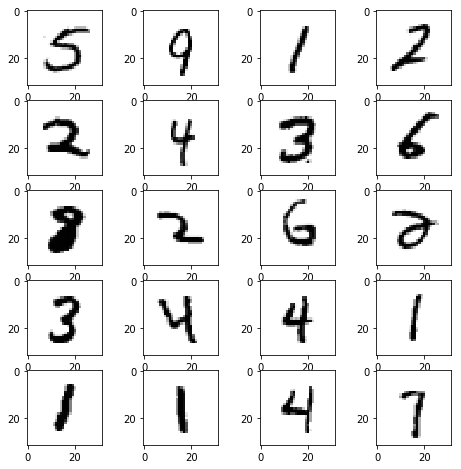

[5, 9, 1, 2, 2, 4, 3, 6, 8, 2, 6, 2, 3, 4, 4, 1, 1, 1, 4, 7]



In [6]:
#Let's print some random digits and their labels
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
label_array = []
for i in range(1, columns*rows+1):
    randomNum = random.randint(0,55000)
    label_array.append(train_labels[randomNum])
    image = train_images[randomNum]
    fig.add_subplot(rows, columns, i)
    plt.imshow(image, cmap="gray_r")
plt.show()
print(label_array)
print()

In [7]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(model_fn=lenet_fn)

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

# Train the model
train_input = input_fn(train_images, train_labels, BATCH_SIZE)

mnist_classifier.train(
    input_fn=train_input,
    steps=20000,
    hooks=[logging_hook])

# Evaluate the model and print results
eval_input = input_fn(test_images, test_labels, BATCH_SIZE)
eval_results = mnist_classifier.evaluate(input_fn=eval_input)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_session_config': None, '_save_summary_steps': 100, '_global_id_in_cluster': 0, '_num_worker_replicas': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E0A4E00E80>, '_master': '', '_tf_random_seed': None, '_task_type': 'worker', '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_train_distribute': None, '_model_dir': 'C:\\Users\\Tyler\\AppData\\Local\\Temp\\tmpziqot_8y', '_task_id': 0, '_save_checkpoints_steps': None, '_evaluation_master': '', '_save_checkpoints_secs': 600}


TypeError: unsupported callable